In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Concatenate, Multiply
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
import matplotlib.pyplot as plt

2024-10-16 20:49:57.059125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load the dataset
data = pd.read_csv('./changhua_data.csv')

# Extract columns
# Assume: First column is time, second column is flow, third to ninth are rainfall data
times = pd.to_datetime(data.iloc[:, 0].values)  # Convert time to datetime
flows = data.iloc[:, 1].values.reshape(-1, 1)
rainfalls = data.iloc[:, 2:].values
print("rainfall shape",rainfalls.shape)

# Create sequences for time-series prediction
def create_sequences(data, target, input_steps, output_steps):
    X, y, times_seq = [], [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:(i + input_steps), :])
        y.append(target[(i + input_steps):(i + input_steps + output_steps), 0])
        times_seq.append(times[i + input_steps:(i + input_steps + output_steps)])
    return np.array(X), np.array(y), np.array(times_seq)

input_steps = 12  # Use past 12 hours
output_steps = 6  # Predict next 6 hours

# Data preprocessing
scaler_flow = MinMaxScaler()
flows_scaled = scaler_flow.fit_transform(flows)

scaler_rainfall = MinMaxScaler()
rainfalls_scaled = scaler_rainfall.fit_transform(rainfalls)

# Combine rainfall and flow data for sequence creation
combined_data = np.concatenate((rainfalls_scaled, flows_scaled), axis=1)

# Create sequences
X, y, times_seq = create_sequences(combined_data, flows_scaled, input_steps, output_steps)

# Train-test split 不按照时间顺序分割
# X_train, X_test, y_train, y_test, times_train, times_test = train_test_split(X, y, times_seq, test_size=0.2, random_state=42)

# Train-test split using time-based split to maintain sequence continuity 按照时间顺序分割
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
times_train, times_test = times_seq[:split_index], times_seq[split_index:]

rainfall shape (9371, 7)


In [7]:
# DeepONet implementation
# Branch Network: U-Net with CBAM
from tensorflow.keras.layers import Conv1D, UpSampling1D, MaxPooling1D, concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D, Reshape, Dense, multiply, add, Activation

# Convolutional Block Attention Module (CBAM)
def cbam_block(input_feature, ratio=8):
    # Channel Attention Module
    channel = input_feature.shape[-1]
    shared_layer_one = Dense(channel // ratio, activation='relu')
    shared_layer_two = Dense(channel)
    
    avg_pool = GlobalAveragePooling1D()(input_feature)
    avg_pool = Reshape((1, channel))(avg_pool)
    avg_pool = shared_layer_one(avg_pool)
    avg_pool = shared_layer_two(avg_pool)
    
    max_pool = GlobalMaxPooling1D()(input_feature)
    max_pool = Reshape((1, channel))(max_pool)
    max_pool = shared_layer_one(max_pool)
    max_pool = shared_layer_two(max_pool)
    
    cbam_feature = add([avg_pool, max_pool])
    cbam_feature = Activation('sigmoid')(cbam_feature)
    cbam_feature = multiply([input_feature, cbam_feature])
    
    # Spatial Attention Module
    avg_pool = tf.reduce_mean(cbam_feature, axis=-1, keepdims=True)
    max_pool = tf.reduce_max(cbam_feature, axis=-1, keepdims=True)
    concat = concatenate([avg_pool, max_pool], axis=-1)
    cbam_feature = Conv1D(filters=1, kernel_size=7, padding='same', activation='sigmoid')(concat)
    cbam_feature = multiply([cbam_feature, input_feature])
    
    return cbam_feature

# U-Net with CBAM
branch_input = Input(shape=(input_steps, X_train.shape[2] - 1), name='branch_input')
conv1 = Conv1D(64, 3, activation='relu', padding='same')(branch_input)
conv1 = cbam_block(conv1)
pool1 = MaxPooling1D(pool_size=2)(conv1)

conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)
conv2 = cbam_block(conv2)
pool2 = MaxPooling1D(pool_size=2)(conv2)

conv3 = Conv1D(256, 3, activation='relu', padding='same')(pool2)
conv3 = cbam_block(conv3)

up4 = UpSampling1D(size=2)(conv3)
up4 = concatenate([up4, conv2], axis=-1)
conv4 = Conv1D(128, 3, activation='relu', padding='same')(up4)
conv4 = cbam_block(conv4)

up5 = UpSampling1D(size=2)(conv4)
up5 = concatenate([up5, conv1], axis=-1)
conv5 = Conv1D(64, 3, activation='relu', padding='same')(up5)
conv5 = cbam_block(conv5)

branch_output = Conv1D(32, 1, activation='relu')(conv5)

# Trunk Network: Takes the flow data as input
# trunk_input = Input(shape=(input_steps, 1), name='trunk_input')
# trunk_lstm = LSTM(64, activation='relu')(trunk_input)
# trunk_output = Dense(32, activation='relu')(trunk_lstm)

# Trunk Network: Replace LSTM with FNN (Fully Connected Neural Network)
trunk_input = Input(shape=(input_steps, 1), name='trunk_input')
flatten_input = tf.keras.layers.Flatten()(trunk_input)
trunk_dense_1 = Dense(64, activation='relu')(flatten_input)
trunk_dense_2 = Dense(32, activation='relu')(trunk_dense_1)
trunk_output = trunk_dense_2

# Replace pointwise multiplication with FNO and GRU layers
# Fourier Neural Operator (FNO) layer
from tensorflow.keras.layers import Conv1D, LayerNormalization

fno_layer_1 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(branch_output[:, None, :])
fno_layer_2 = Conv1D(filters=32, kernel_size=3, padding='same', activation='relu')(fno_layer_1)
fno_layer_2 = tf.squeeze(fno_layer_2, axis=1)

# GRU layers
gru_layer_1 = LSTM(32, return_sequences=True, activation='relu')(fno_layer_2)
gru_layer_2 = LSTM(32, activation='relu')(gru_layer_1)

# Combine FNO and GRU output
combined = Multiply()([trunk_output, gru_layer_2])
combined_output = Dense(output_steps, activation='linear')(combined)

# Physics-Informed Neural Networks (PINN) Loss
# Custom loss function that incorporates both data loss and physical loss

def pinn_loss(y_true, y_pred):
    # Initialize self-adaptive weights as trainable variables
    if not hasattr(pinn_loss, 'data_weight'):
        pinn_loss.data_weight = tf.Variable(0.7, trainable=True, dtype=tf.float32, name='data_weight')
    if not hasattr(pinn_loss, 'physics_weight'):
        pinn_loss.physics_weight = tf.Variable(0.3, trainable=True, dtype=tf.float32, name='physics_weight')

    # Mean squared error loss for data fitting
    data_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Physics loss: based on Saint-Venant equations residuals
    g = 9.81  # gravitational acceleration (m/s^2)
    physics_loss = 0
    for i in range(1, output_steps):
        # Approximate depth (h) and velocity (u) based on predictions
        h = y_pred[:, i]
        h_prev = y_pred[:, i - 1]
        
        # Mass conservation residual (continuity equation)
        dh_dt = (h - h_prev) / (1.0)  # Simplified time derivative (assuming unit time step)
        physics_mass_residual = dh_dt  # In reality, add spatial flow divergence terms
        
        # Momentum conservation residual (momentum equation)
        du_dt = (h - h_prev) / (1.0)  # Simplified time derivative for velocity
        slope_term = -g * (h - h_prev) / (1.0)  # Simplified slope term
        physics_momentum_residual = du_dt + slope_term
        
        # Combine physics residuals
        physics_loss += tf.reduce_mean(tf.square(physics_mass_residual))
        physics_loss += tf.reduce_mean(tf.square(physics_momentum_residual))
    
    # Boundary condition: assume known boundary condition at the beginning and end of prediction
    boundary_condition_loss = tf.reduce_mean(tf.square(y_pred[:, 0] - y_true[:, 0]))
    boundary_condition_loss += tf.reduce_mean(tf.square(y_pred[:, -1] - y_true[:, -1]))
    
    # Initial condition loss: make sure the initial state is consistent
    initial_condition_loss = tf.reduce_mean(tf.square(y_pred[:, 0] - y_true[:, 0]))
    
    # Combine physics losses
    total_physics_loss = physics_loss + boundary_condition_loss + initial_condition_loss
    
    # Compute gradients for GradNorm
    with tf.GradientTape() as tape:
        tape.watch([pinn_loss.data_weight, pinn_loss.physics_weight])
        weighted_total_loss = pinn_loss.data_weight * data_loss + pinn_loss.physics_weight * total_physics_loss
    grads = tape.gradient(weighted_total_loss, [pinn_loss.data_weight, pinn_loss.physics_weight])
    grad_data, grad_physics = grads[0], grads[1]

    # Compute GradNorm adjustment
    target_ratio = 1.0  # Define target ratio for balancing gradients
    grad_norm_ratio = tf.clip_by_value(tf.abs(grad_data) / (tf.abs(grad_physics) + 1e-2), 0.1, 10.0)  # Clip to prevent extreme values
    grad_adjustment = tf.clip_by_value(target_ratio / (grad_norm_ratio + 1e-2), 0.1, 10.0)  # Clip adjustment to stabilize training

    # Adjust self-adaptive weights using GradNorm
    # pinn_loss.data_weight.assign(pinn_loss.data_weight * grad_adjustment)
    # pinn_loss.physics_weight.assign(pinn_loss.physics_weight / grad_adjustment)

    # Adjust self-adaptive weights using GradNorm with a learning rate
    adjustment_lr = 0.01  # Learning rate for adjusting weights
    new_data_weight = pinn_loss.data_weight * (1.0 + adjustment_lr * (grad_adjustment - 1.0))
    new_physics_weight = pinn_loss.physics_weight * (1.0 - adjustment_lr * (grad_adjustment - 1.0))

    pinn_loss.data_weight.assign(tf.clip_by_value(new_data_weight, 0.1, 10.0))
    pinn_loss.physics_weight.assign(tf.clip_by_value(new_physics_weight, 0.1, 10.0))
    pinn_loss.data_weight.assign(pinn_loss.data_weight * grad_adjustment)
    pinn_loss.physics_weight.assign(pinn_loss.physics_weight / grad_adjustment)


    # Combine all losses
    total_loss = pinn_loss.data_weight * data_loss + pinn_loss.physics_weight * total_physics_loss
    return total_loss

# Model definition
model = Model(inputs=[branch_input, trunk_input], outputs=combined_output)
model.compile(optimizer='adam', loss=pinn_loss, metrics=['mae'])
# model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Training the model
history = model.fit([X_train[:, :, :-1], X_train[:, :, -1:]], y_train, epochs=10, batch_size=16, validation_split=0.1)

# Evaluate the model
evaluation = model.evaluate([X_test[:, :, :-1], X_test[:, :, -1:]], y_test)
print(f'Test Loss: {evaluation[0]}, Test MAE: {evaluation[1]}')

# Make predictions
predictions = model.predict([X_test[:, :, :-1], X_test[:, :, -1:]])

# Only keep the first future step predictions to avoid overlap
predictions = predictions[:, 0].reshape(-1, 1)
y_test = y_test[:, 0].reshape(-1, 1)

# Inverse transform the predicted flows to original scale
predicted_flows = scaler_flow.inverse_transform(predictions)
y_test_inverse = scaler_flow.inverse_transform(y_test)
y_test_inverse = scaler_flow.inverse_transform(y_test)

# Display predictions
results = pd.DataFrame({'Actual Flow': y_test_inverse.flatten(), 'Predicted Flow': predicted_flows.flatten()})
print(results.head())

Epoch 1/10
421/421 [==============================] - 18s 23ms/step - loss: 0.4490 - mae: 0.0392 - val_loss: 0.0284 - val_mae: 0.0128
Epoch 2/10
421/421 [==============================] - 7s 17ms/step - loss: 0.1924 - mae: 0.0214 - val_loss: 0.0177 - val_mae: 0.0080
Epoch 3/10
421/421 [==============================] - 7s 17ms/step - loss: 0.1475 - mae: 0.0175 - val_loss: 0.0149 - val_mae: 0.0069
Epoch 4/10
421/421 [==============================] - 7s 17ms/step - loss: 0.1467 - mae: 0.0171 - val_loss: 0.0281 - val_mae: 0.0082
Epoch 5/10
421/421 [==============================] - 7s 18ms/step - loss: 0.1181 - mae: 0.0149 - val_loss: 0.0165 - val_mae: 0.0078
Epoch 6/10
421/421 [==============================] - 8s 18ms/step - loss: 0.1068 - mae: 0.0140 - val_loss: 0.0147 - val_mae: 0.0061
Epoch 7/10
421/421 [==============================] - 8s 18ms/step - loss: 0.1024 - mae: 0.0137 - val_loss: 0.0217 - val_mae: 0.0067
Epoch 8/10
421/421 [==============================] - 8s 18ms/step -

MAE: 10.944674292125528, MAPE: 0.14071649285479423, R^2: 0.9598687536673282


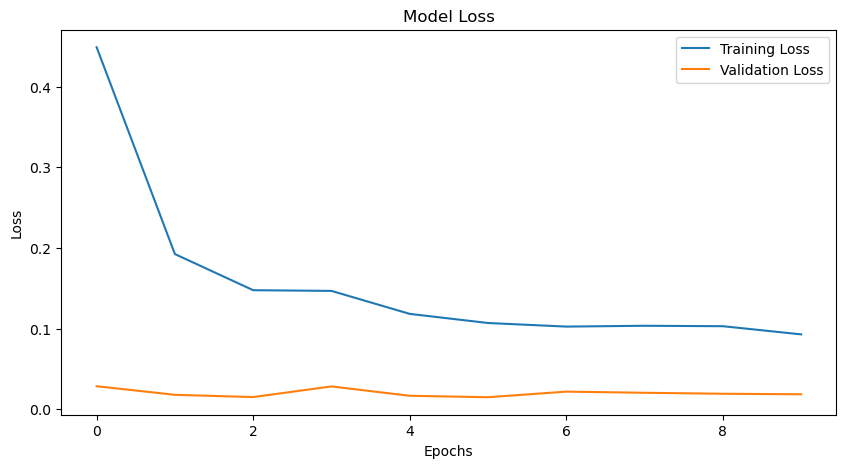

In [8]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test_inverse.flatten(), predicted_flows.flatten())
mape = mean_absolute_percentage_error(y_test_inverse.flatten(), predicted_flows.flatten())
r2 = r2_score(y_test_inverse.flatten(), predicted_flows.flatten())
print(f'MAE: {mae}, MAPE: {mape}, R^2: {r2}')

# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

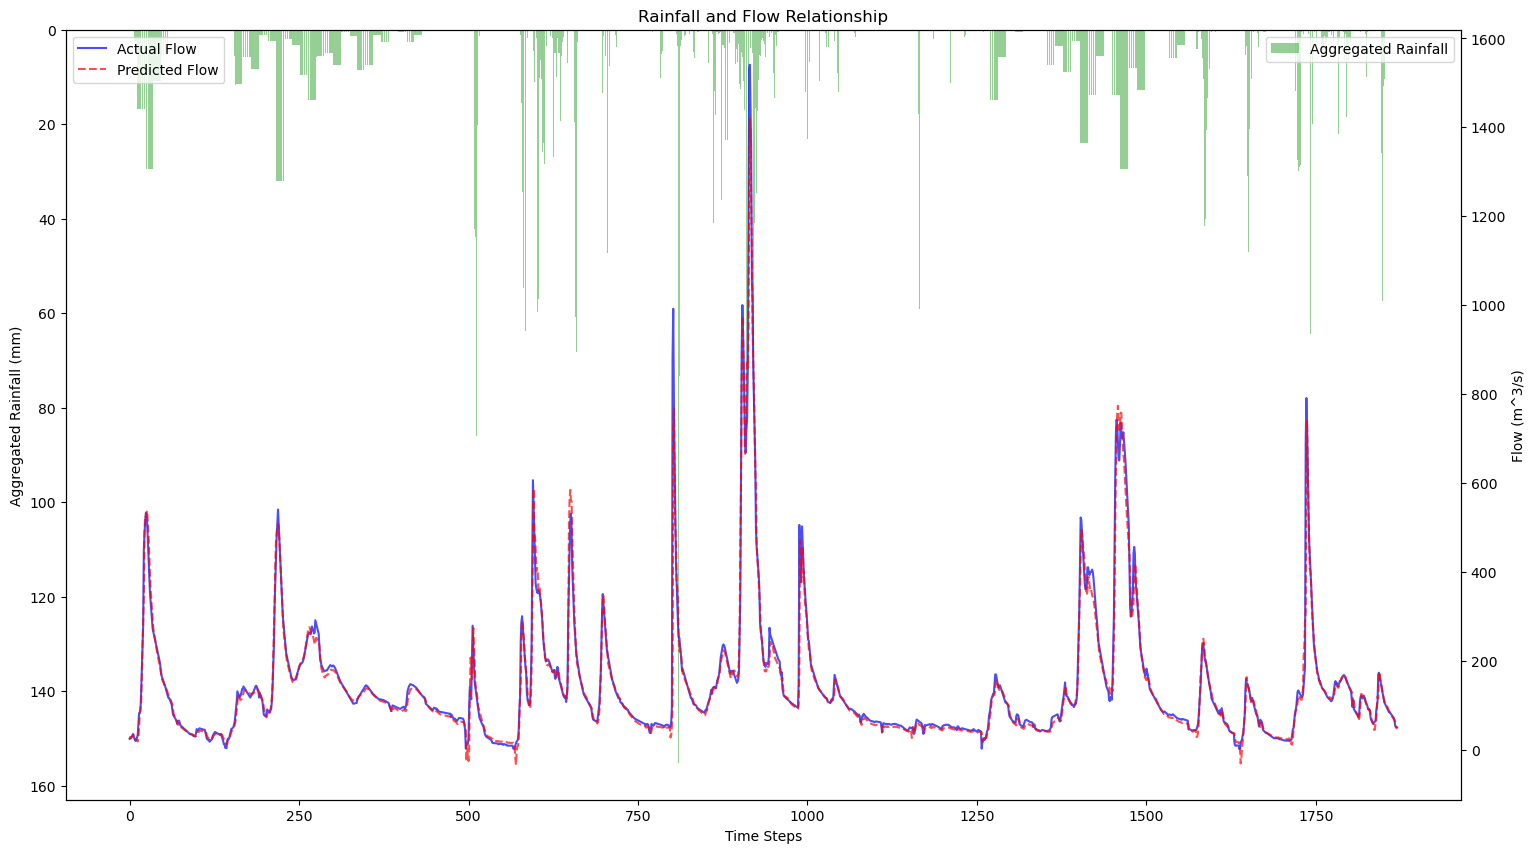

In [9]:
# Plot rainfall-flow dual-axis chart for actual vs predicted flows along with aggregated rainfall
fig, ax1 = plt.subplots(figsize=(18, 10))
draw_len = len(y_test_inverse)

# Use first 100 data points for plotting
time_steps = np.arange(draw_len)
# aggregated_rainfall = scaler_rainfall.inverse_transform(X_test[:draw_len, :, :-1].reshape(-1, X_test.shape[2] - 1)).sum(axis=1).reshape(draw_len, -1).mean(axis=1)
aggregated_rainfall = scaler_rainfall.inverse_transform(X_test[:draw_len, :, :-1].reshape(-1, X_test.shape[2] - 1)).sum(axis=1).reshape(draw_len, -1)[:,0]

# Plot aggregated rainfall as a bar chart, pointing downwards
ax1.bar(time_steps, aggregated_rainfall, color='tab:green', alpha=0.5, label='Aggregated Rainfall')
ax1.invert_yaxis()
ax1.set_xlabel('Time Steps')
ax1.set_ylabel('Aggregated Rainfall (mm)')
ax1.legend(loc='upper right')
ax1.set_title('Rainfall and Flow Relationship')

# Apply smoothing to actual and predicted flow
actual_flow = y_test_inverse[:draw_len, 0]
predicted_flow = predicted_flows[:draw_len, 0]

# Plot actual and predicted flow
ax2 = ax1.twinx() 
ax2.plot(time_steps, actual_flow, label='Actual Flow', color='blue', alpha=0.7)
ax2.plot(time_steps, predicted_flow, label='Predicted Flow', color='red', linestyle='dashed', alpha=0.7)

ax2.set_ylabel('Flow (m^3/s)')
ax2.legend(loc='upper left')

plt.show()

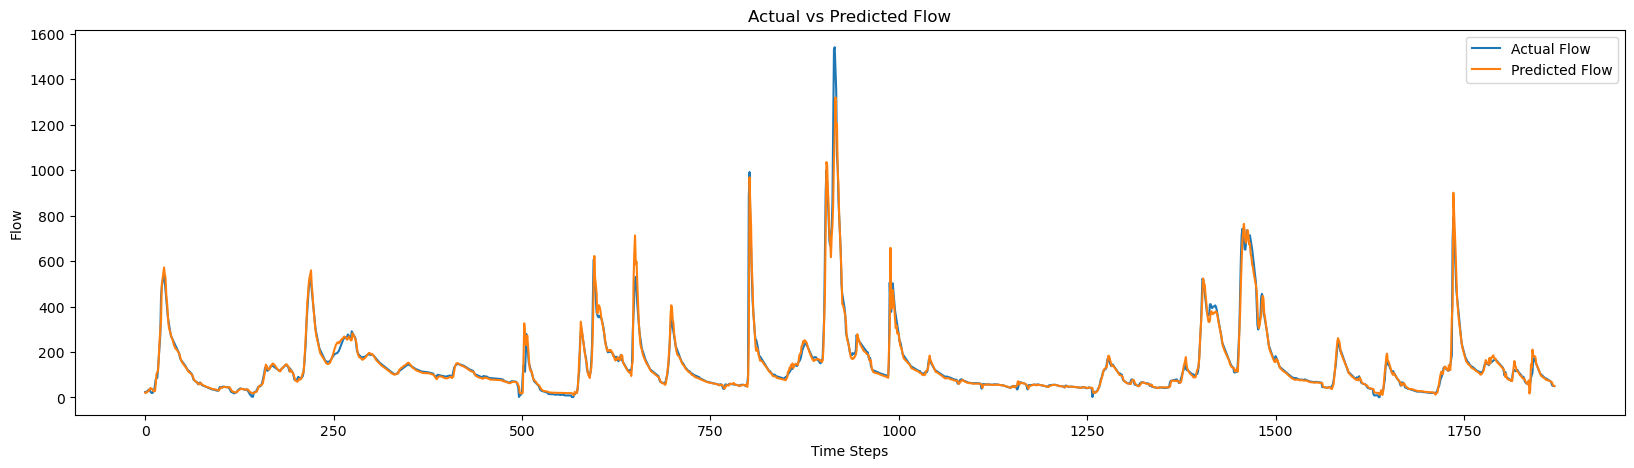

In [22]:
# Plot actual vs predicted flows 全部时间步
plt.figure(figsize=(20, 5))
plt.plot(y_test_inverse.flatten(), label='Actual Flow')
plt.plot(predicted_flows.flatten(), label='Predicted Flow')
plt.xlabel('Time Steps')
plt.ylabel('Flow')
plt.legend()
plt.title('Actual vs Predicted Flow')
plt.show()